In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
image_dir = "/Users/priyanshdesai07/Plaksha/Deep_Learning/dolphin/vig_pytorch/archive/raw-img/cavallo"

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (120, 120))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


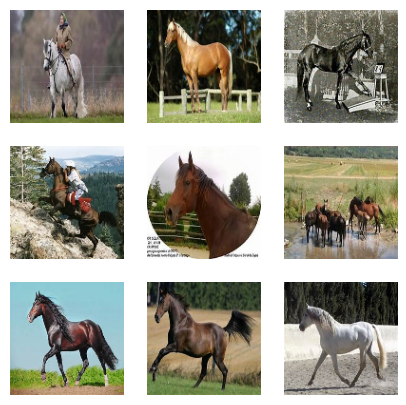

In [5]:
# example of dataset
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [6]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3
    
    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)
    
    return parts

In [7]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))
    
    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())
    
    return combinations, original_positions

In [8]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square
    
    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)
    
    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]
    
    return stitched_image

In [9]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)
    
    for idx, combination in enumerate(combinations):
        shuffled_image = stitch_shuffled_image(combination)
        input_data.append(shuffled_image)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [10]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 120, 120, 3)
Target data shape: (26230, 81)


target
[[0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
non_converted_target [8, 3, 6, 4, 1, 2, 7, 0, 5]


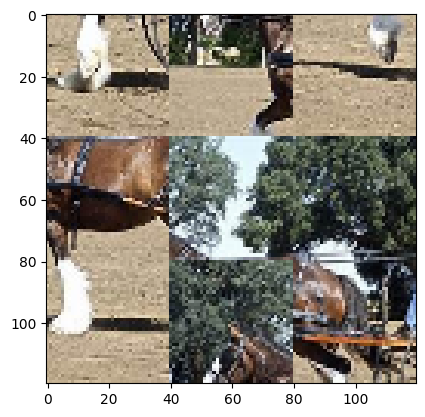

In [11]:
# select random image
idx = random.randint(0, len(input_data))
print("target", target_data[idx].reshape(9, 9), sep="\n")
print("non_converted_target", non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(input_data[idx], cv2.COLOR_BGR2RGB))

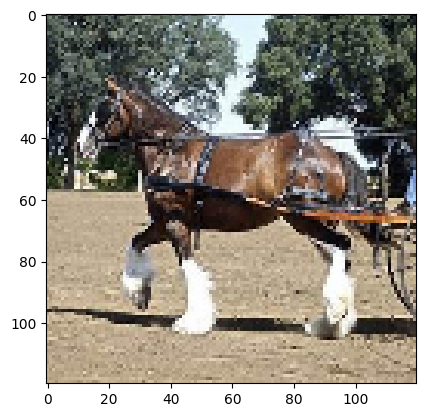

In [12]:
# checking if the target sequence is correct
def reconstructed_image(img, non_converted_target_data):
    
    parts = divide_image(img)
    sequenced = [0] * 9
    for i, part in enumerate(parts):
        sequenced[non_converted_target_data[i]] = part

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img

reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [13]:
class JigsawDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        image = self.input_data[idx]
        target = self.target_data[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [14]:
class JigsawModel(nn.Module):
    def __init__(self):
        super(JigsawModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 15 * 15, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512) 
        self.fc4 = nn.Linear(512, 81)
        
    def forward(self, x):
        conv1_l = []
        x = self.pool(F.relu(self.conv1(x)))
        conv1_l.append(x)
        return x,conv1_l
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        

In [15]:
model = JigsawModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
batch_size = 64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = JigsawDataset(X_train, y_train)
test_dataset = JigsawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [17]:
print(X_train.shape)

(20984, 120, 120, 3)


In [18]:
for epoch in range(num_epochs):
    print('je')
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        print('hello')
        inputs = inputs.permute(0, 3, 1, 2).float()
        optimizer.zero_grad()
        print('hi')
        outputs, conv_l = model(inputs)
        print(len(conv_l))   
        break   
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print('Epoch: %d, Batch: %5d, Loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    break
print('Finished Training')

je
hello
hi
1
Finished Training


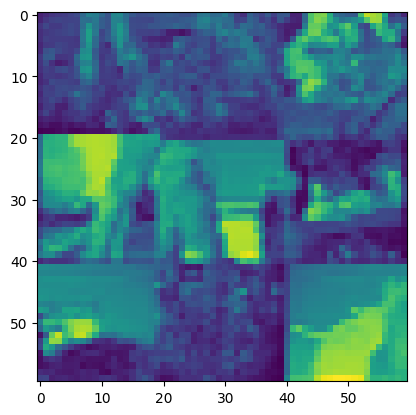

In [34]:
def recur(sequence, outputs):
    sequence = np.array(sequence)
    for i in range(len(sequence)):
        while np.sum(sequence == sequence[i]) > 1:  # If the current element is a duplicate
            # Find the index in outputs for the current sequence element that is not yet in the updated sequence
            scores = outputs[i]
            sorted_indices = np.argsort(scores)[::-1]  # Indices of scores sorted in descending order
            for idx in sorted_indices:
                if idx not in sequence:
                    sequence[i] = idx
                    break
                
    return sequence.tolist()

In [35]:
correct = 0
total = 0
per_tile_accuracy = 0

model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2).float()
        outputs = model(inputs)

        # reshape the output to 9x9 matrix
        outputs = outputs.reshape(-1, 9, 9)
        predicted = torch.argmax(outputs, dim=1)

        # now doing the same for the target
        labels = labels.reshape(-1, 9, 9)
        target = torch.argmax(labels, dim=1)

        # check if the predicted sequence is correct
        for i in range(len(predicted)):
            updated_predicted = recur(predicted[i], outputs[i, : , :].numpy())
            
            if torch.equal(torch.tensor(updated_predicted), target[i]):
                correct += 1
            total += 1

            per_tile_accuracy += (np.array(updated_predicted) == target[i].numpy()).sum() / 9

print('Accuracy on test images: %d %%' % (100 * correct / total))
print('Per tile accuracy on test images: %d %%' % (100 * per_tile_accuracy / total))

Accuracy on test images: 0 %
Per tile accuracy on test images: 10 %


target
[[0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0]]
converted target
[2 5 7 6 3 0 4 8 1]
outputs
tensor([[ 0.0361,  0.0059, -0.0150,  0.0104,  0.0323,  0.0299, -0.0211,  0.0334,
          0.0136],
        [-0.0257, -0.0097,  0.0174,  0.0382,  0.0301,  0.0115,  0.0050,  0.0455,
         -0.0039],
        [ 0.0193, -0.0133,  0.0302,  0.0351,  0.0383, -0.0535,  0.0100,  0.0232,
          0.0226],
        [ 0.0478, -0.0060,  0.0242,  0.0219, -0.0103,  0.0220,  0.0029, -0.0054,
          0.0145],
        [ 0.0028,  0.0398,  0.0236,  0.0297, -0.0082, -0.0137,  0.0036,  0.0198,
          0.0217],
        [-0.0034,  0.0364,  0.0501, -0.0083,  0.0310,  0.0258,  0.0283, -0.0135,
         -0.0299],
        [ 0.0244,  0.0036,  0.0244, -0.0143, -0.0150, -0.0014,  0.0545, -0.0067,
          0.0342],
        [ 0.0100,  0.0510, -0.0052, -0.0146, -0.0213,  0.0

Text(0.5, 1.0, 'with predicted sequence')

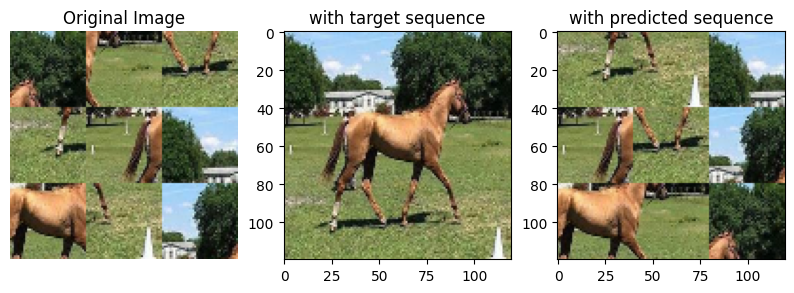

In [36]:
# select random image from test set
idx = random.randint(0, len(X_test))
image = X_test[idx]
target = y_test[idx]


plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
print("target", target.reshape(9, 9), sep="\n")
converted_target = np.argmax(target.reshape(9, 9), axis=1)
print("converted target", converted_target, sep="\n")
reconstructed_img = reconstructed_image(image, converted_target)
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('with target sequence')
                 
plt.subplot(133)
inputs = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
outputs = model(inputs)
outputs = outputs.reshape(9, 9)
print("outputs", outputs, sep="\n")

predicted = torch.argmax(outputs, dim=1)
print("predicted", predicted, sep="\n")
updated_predicted = recur(predicted, outputs.detach().numpy())
print("updated predicted", updated_predicted, sep="\n")

reconstructed_img = reconstructed_image(image, updated_predicted)
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
plt.title('with predicted sequence')